<h1 id="Contents">Contents<a href="#Contents"></a></h1>
        <ol>
        <li><a class="" href="#Imports">Imports</a></li>
<li><a class="" href="#Defining-the-Data-Directory-and-Result-Directory">Defining the Data Directory and Result Directory</a></li>
<li><a class="" href="#Initializing-the-Classes">Initializing the Classes</a></li>
<li><a class="" href="#Extracting-Information">Extracting Information</a></li>
<ol><li><a class="" href="#Determining-the-Region-of-Interest">Determining the Region of Interest</a></li>
<li><a class="" href="#Reiniatilizing-the-Classes">Reiniatilizing the Classes</a></li>
<li><a class="" href="#Setting-the-Reference-Image">Setting the Reference Image</a></li>
<li><a class="" href="#Extracting-Center-Related-Information">Extracting Center Related Information</a></li>
<li><a class="" href="#Some-Preliminary-Analysis">Some Preliminary Analysis</a></li>
<ol><li><a class="" href="#None-Values">None Values</a></li>
<li><a class="" href="#Sample-Images">Sample Images</a></li>
</ol><li><a class="" href="#Extracting-Objectives">Extracting Objectives</a></li>
<ol><li><a class="" href="#Getting-Frame-Information">Getting Frame Information</a></li>
<li><a class="" href="#Getting-Angle-and-Velocity">Getting Angle and Velocity</a></li>
<li><a class="" href="#The-Additional-Information">The Additional Information</a></li>
<li><a class="" href="#Adding-the-Additional-Information">Adding the Additional Information</a></li>
<li><a class="" href="#Save-the-DataFrame">Save the DataFrame</a></li>
</ol>

# Imports

In [5]:
from extract_center import CenterExtracter
from run import Run
from misc_tools import Plotter, Smoother
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Defining the Data Directory and Result Directory

In [6]:
sequence = "h7"
DATA_DIR = '../../data/extracted_images/' + sequence
RESULT_DIR = '../../data/results/' + sequence

# Initializing the Classes

In [7]:
run = Run(DATA_DIR, RESULT_DIR)
ce = CenterExtracter()

# Extracting Information

## Determining the *Region of Interest*

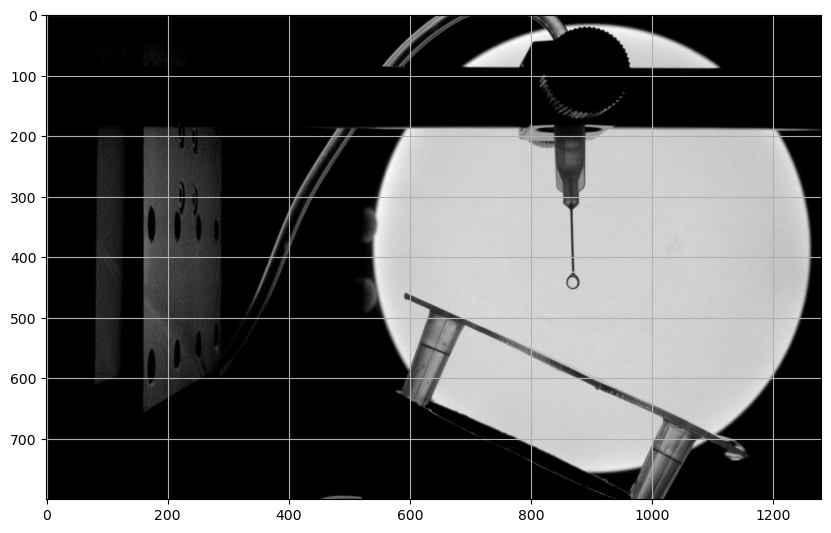

In [8]:
images = run.get_images()
img_1 = ce._read_image(images[0])
ce._show_image(img_1)

In [9]:
region_of_interset = (800, 400, 1200, 700)

## Reiniatilizing the Classes

In [10]:
run = Run(DATA_DIR, RESULT_DIR, region = region_of_interset)

## Setting the Reference Image

In [11]:
run._set_ref_image(-10)

## Extracting Center Related Information

In [12]:
df = run.all_points(crop_included=True, binary=True, verbose=False, num_images=None, raise_error=False)

Getting list of images...
Extracting data from images...


Extracting data from images: 100%|██████████| 273/273 [00:15<00:00, 18.01it/s]

Saving to csv...
Done!


## Some Preliminary Analysis

### None Values

In [13]:
df.isna().sum()

id         0
x        120
y        120
r1       120
r2       120
theta    120
dtype: int64

In [14]:
none_values = df.isna().sum()["x"]
total_frames = len(df)
unrealistic = len(df[((df["r1"]+df["r2"])/2>20)|((df["r1"]+df["r2"])/2<5)])

In [15]:
df = pd.read_csv(RESULT_DIR + '/centers_using_ap.csv')

### Sample Images

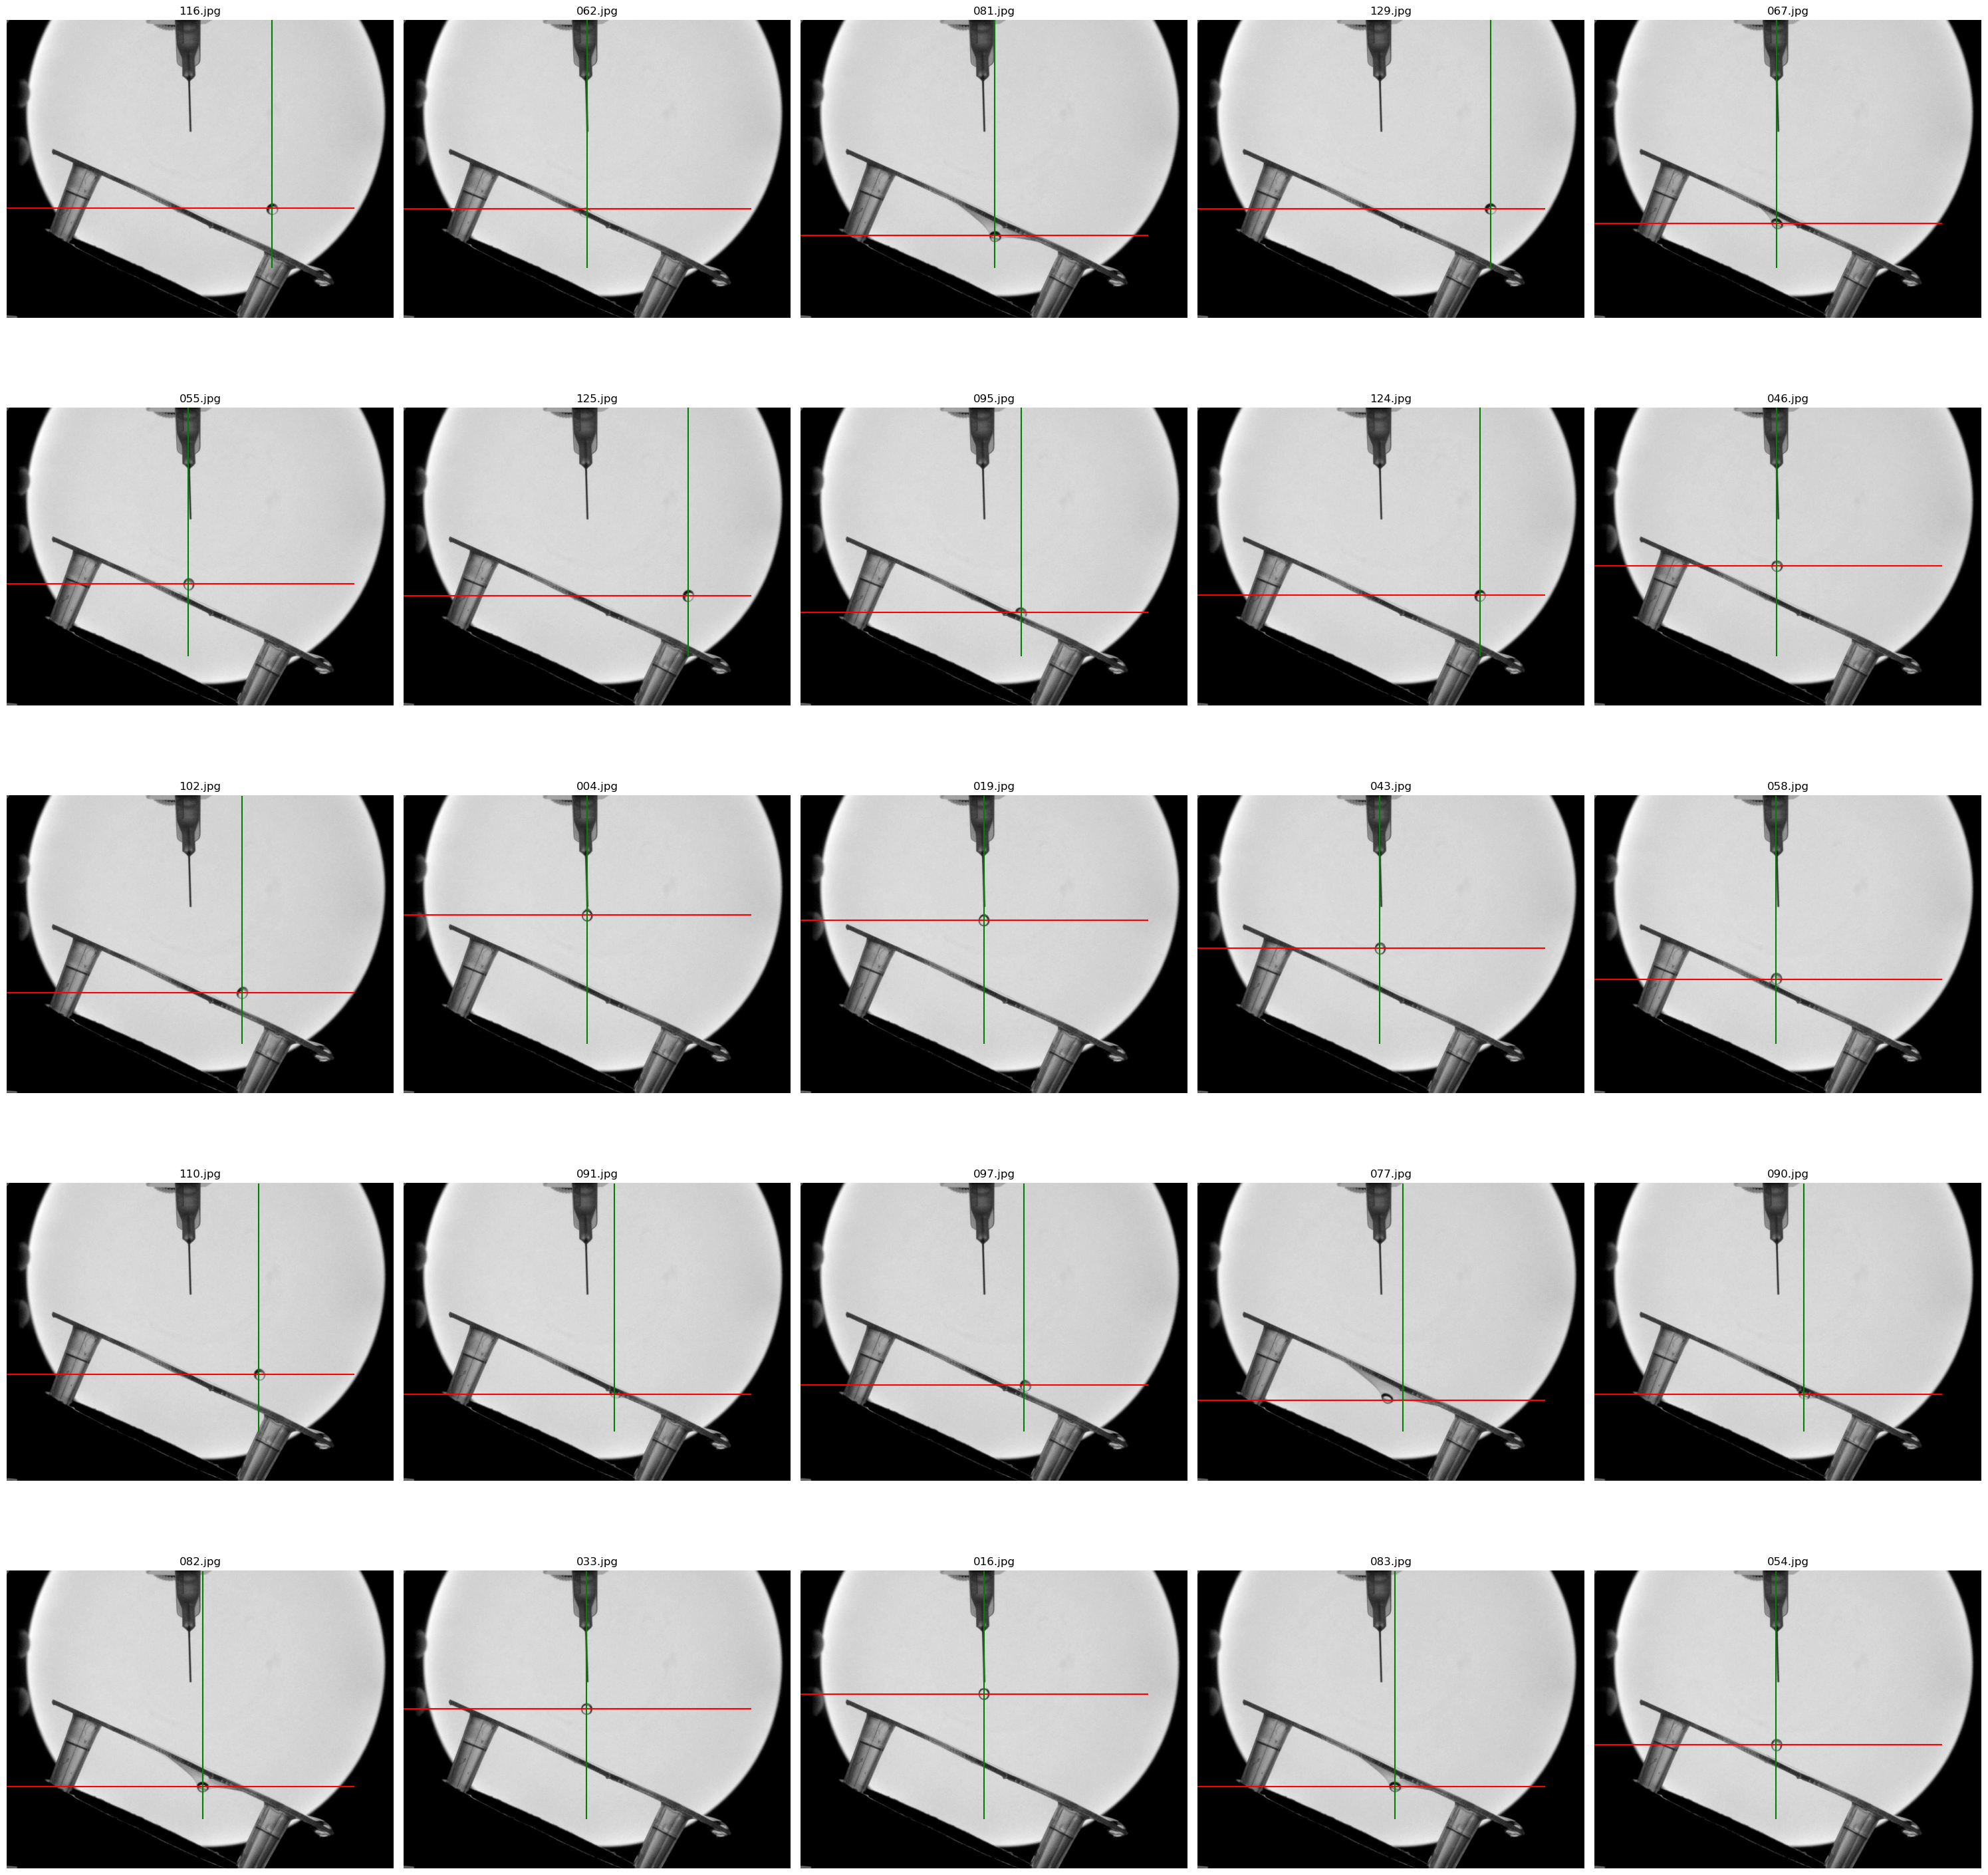

In [16]:
p = Plotter(df, RESULT_DIR)
p.get_samples(25, file_name = f"{sequence}_samples.png")

## Extracting Objectives

### Getting Frame Information

In [17]:
info_dict = {
    "first_frame": 1,
    "last_frame": 2,
    "contact_frame": 3,
    "leave_frame": 4,
    "angle": 5,
}

In [18]:
def update_info(file, info, line_num = 4):
    with open(file, "r") as f:
        texts = f.readlines()
    line = texts[line_num]
    value = line.split(":")[1].strip()
    if value == "":
        line = line.split(":")[0] + ": " + info + "\n"
        texts[line_num] = line
    else:
        texts[line_num] = line
    with open(file, "w") as f:
        f.writelines(texts)
    return texts[line_num]
leave_frame = df[df["y"] == df["y"].max()]["id"].values[-1].split("/")[-1]
last_frame = df.iloc[-10]["id"].split("/")[-1]
update_info(f"{DATA_DIR}.txt", leave_frame, line_num = 4)
update_info(f"{DATA_DIR}.txt", last_frame, line_num = 2)

'### Last Frame ID: 263.jpg\n'

In [19]:
def get_info(file):
    information = {}
    with open(file, "r") as f:
        texts = f.readlines()
    for key, value in info_dict.items():
        line = texts[value]
        info = line.split(":")[1].strip()
        information[key] = info
    return information

information = get_info(f"{DATA_DIR}.txt")

In [20]:
first_frame = DATA_DIR + "/" +information["first_frame"]
last_frame = DATA_DIR + "/" +information["last_frame"]
contact_frame = DATA_DIR + "/" +information["contact_frame"]
angle = information["angle"]
leave_frame = DATA_DIR + "/" +information["leave_frame"]

In [21]:
first_frame, last_frame

('../../data/extracted_images/h7/006.jpg',
 '../../data/extracted_images/h7/263.jpg')

### Getting Angle and Velocity

In [22]:
s = Smoother(df)
df_s = s.smoothen(remove_noise = False)

c:\Users\harik\Desktop\mini-project\codes\extraction\misc_tools.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["r"] = ((df["r1"] + df["r2"]) / 2).astype(int)
c:\Users\harik\Desktop\mini-project\codes\extraction\misc_tools.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = self.savitzky_golay(col_value, window_size=w, order=order)


In [23]:
df_s["vx"] = df_s["x"].diff(7)/7
df_s["vy"] = df_s["y"].diff(7)/7

df_s.dropna(inplace=True)
df_s["v"] = np.sqrt(df_s["vx"]**2 + df_s["vy"]**2)

C:\Users\harik\AppData\Local\Temp\ipykernel_8860\3680160857.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_s["vx"] = df_s["x"].diff(7)/7
C:\Users\harik\AppData\Local\Temp\ipykernel_8860\3680160857.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_s["vy"] = df_s["y"].diff(7)/7
C:\Users\harik\AppData\Local\Temp\ipykernel_8860\3680160857.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/

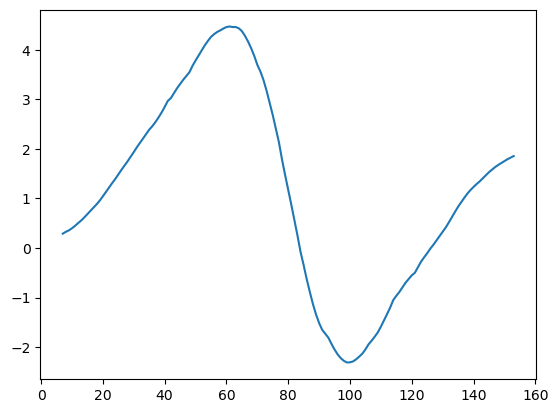

In [24]:
plt.plot(df_s["vy"])

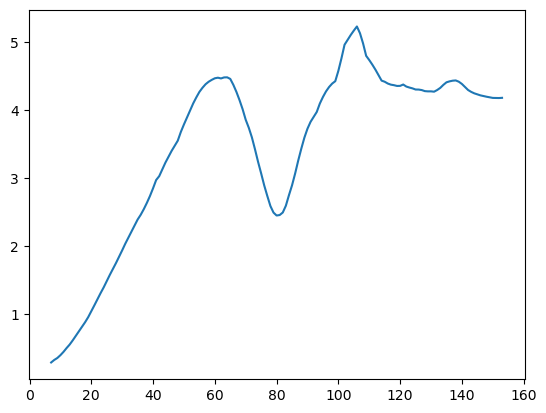

In [25]:
plt.plot(df_s["v"])

In [26]:
def get_angle(row):
    vx = row["vx"]
    vy = -row["vy"]
    if vx == 0 and vy == 0:
        return 0
    elif vx==0:
        return 90
    else:
        return np.arctan(vy/vx)*180/np.pi

In [27]:
df_s["angle"] = df_s.apply(get_angle, axis=1)

C:\Users\harik\AppData\Local\Temp\ipykernel_8860\1865048196.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_s["angle"] = df_s.apply(get_angle, axis=1)


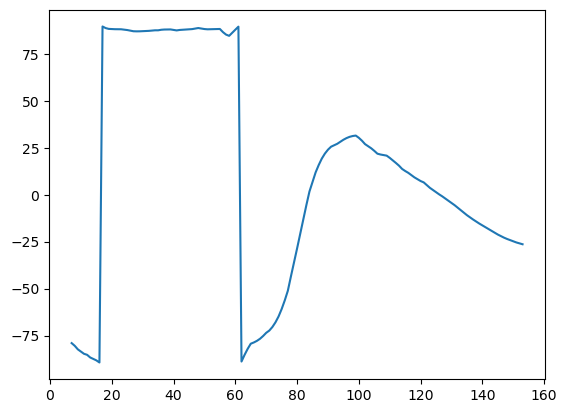

In [28]:
plt.plot(df_s["angle"])

### The Additional Information

In [29]:
df_s[df_s["id"] == contact_frame].T

59
id     ../../data/extracted_images/h7/059.jpg
x                                  864.074872
y                                  573.877103
r1                                   6.488561
r2                                   9.638117
theta                               88.474043
r                                    7.828134
vx                                  -0.291035
vy                                   4.432056
v                                    4.441601
angle                                86.24301

In [30]:
df_s[df_s["id"] == leave_frame].T

79
id     ../../data/extracted_images/h7/079.jpg
x                                  891.598223
y                                  633.990925
r1                                  14.235205
r2                                  10.321611
theta                               76.451788
r                                   12.060314
vx                                   2.013613
vy                                   1.471923
v                                    2.494232
angle                              -36.166278

In [31]:
reg = re.compile(r"\d{3}")
contact_frame_num = int(reg.findall(contact_frame)[0])
leave_frame_num = int(reg.findall(leave_frame)[0])
contact_frame_num, leave_frame_num

(59, 79)

In [32]:
angle_at_contact_frame = df_s.loc[contact_frame_num]["angle"]
angle_at_leave_frame = df_s.loc[leave_frame_num]["angle"]

if angle_at_contact_frame<0:
    angle_at_contact_frame = 180 + angle_at_contact_frame

angle_at_contact_frame, angle_at_leave_frame

(86.24301013139517, -36.16627777823352)

In [33]:
velocity_at_leave_frame = df_s.loc[leave_frame_num]["v"]
velocity_at_contact_frame = df_s.loc[contact_frame_num]["v"]
velocity_at_leave_frame, velocity_at_contact_frame

(2.4942323183313304, 4.441601030103657)

In [34]:
x_velocity_at_leave_frame = df_s.loc[leave_frame_num]["vx"]
x_velocity_at_contact_frame = df_s.loc[contact_frame_num]["vx"]

y_velocity_at_leave_frame = df_s.loc[leave_frame_num]["vy"]
y_velocity_at_contact_frame = df_s.loc[contact_frame_num]["vy"]

### Adding the Additional Information

In [35]:
pattern = "***"
information = f"""\n{pattern*20}
### TOTAL FRAMES: {total_frames}
### NONE FRAMES: {none_values}
### UNREALISTIC FRAMES: {unrealistic}
{pattern*20}
AT CONTACT FRAME:
### ANGLE: {np.round(-90+angle_at_contact_frame+float(angle), 2)}
### VELOCITY: {np.round(velocity_at_contact_frame, 2)}
### X VELOCITY: {np.round(x_velocity_at_contact_frame, 2)}
### Y VELOCITY: {np.round(y_velocity_at_contact_frame, 2)}

AT LEAVE FRAME:
### ANGLE: {np.round(angle_at_leave_frame, 2)}
### VELOCITY: {np.round(velocity_at_leave_frame, 2)}
### X VELOCITY: {np.round(x_velocity_at_leave_frame, 2)}
### Y VELOCITY: {np.round(y_velocity_at_leave_frame, 2)}
{pattern*20}"""
print(information)


************************************************************
### TOTAL FRAMES: 273
### NONE FRAMES: 120
### UNREALISTIC FRAMES: 5
************************************************************
AT CONTACT FRAME:
### ANGLE: 21.24
### VELOCITY: 4.44
### X VELOCITY: -0.29
### Y VELOCITY: 4.43

AT LEAVE FRAME:
### ANGLE: -36.17
### VELOCITY: 2.49
### X VELOCITY: 2.01
### Y VELOCITY: 1.47
************************************************************


First, remove anything between the asterisks.

In [36]:
with open(DATA_DIR+".txt", "r") as f:
    texts = f.readlines()
text = "".join(texts[:6])
print(text)
all_text = text+information

### h7.tif
### First Frame ID: 006.jpg
### Last Frame ID: 263.jpg
### Contact Frame ID: 059.jpg
### Leave Frame ID: 079.jpg
### Angle: 25



In [37]:
with open(RESULT_DIR +"/info.txt", "w") as f:
    f.writelines(all_text)

### Save the DataFrame

In [38]:
df_s.to_csv(RESULT_DIR + f"/{sequence}_smoothened.csv", index=False)